# DNN: analysis with Keras of 2D data

In [1]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout

import matplotlib as mpl
mpl.rc('image', cmap='copper')
import matplotlib.pyplot as plt
# default font

%run nonlinear_function.py

# training data
perc_train = 0.8

2024-02-27 19:27:07.663158: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-27 19:27:07.716498: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 19:27:07.716534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 19:27:07.717785: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 19:27:07.726116: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-27 19:27:07.726959: I tensorflow/core/platform/cpu_feature_guard.cc:1

2000 2
[-31.60811883 -29.54397214] 0.0
[6.77250291 9.5544703 ] 0.0
[46.45145197 15.31770969] 1.0
[24.89066375 15.35698709] 0.0
[24.77148093 46.13067361] 0.0
[-49.16117021 -39.35556233] 1.0
[-20.12962862  15.64111831] 0.0
[30.98125525 37.21759137] 1.0
[46.46475974 22.36853469] 0.0
[14.24753279 21.74536208] 0.0
data: 2000
train: 1600


<function matplotlib.pyplot.show(close=None, block=None)>

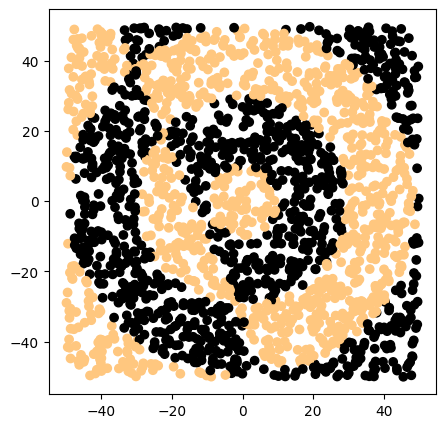

In [2]:
# Keras works with numpy arrays: just use them from the start
TYPE=2
x = np.loadtxt(filename("data",TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",TYPE), delimiter=' ')
N = len(x)

# dimension of a single sample
L = len(x[0])

# dimensions of the total dataset
print(N, L)

# coordinates of the first ten points with labels
for i in range(10):
    print(x[i],y[i])

# Dimension of the train dataset 
N_train = int(perc_train * N)
print(f'data: {N}\ntrain: {N_train}')

plt.figure(figsize = (5,5))
plt.scatter(x[:,0],x[:,1],c=y)
plt.show

### Split training and test data

In [3]:
# training set
(x_train, y_train) = (x[0:N_train],y[0:N_train])

# validation set (we are using the validation as a test set)
(x_valid, y_valid) = (x[N_train:],y[N_train:])

print("Train:",len(x_train),"\t Validation:",len(x_valid))

Train: 1600 	 Validation: 400


### Rescale input data

In [4]:
# we rescale because in the image before we have values between -50 to +50, but we want something between -1 and 1
# we could use the variance but a single number is easier, so keep 50

def Rescale(x):
    # return (x-x.mean())/np.sqrt(x.var())
    return x/50

x_train = Rescale(x_train)
x_valid = Rescale(x_valid)

### Define the model with Keras / Tensorflow

In [5]:
# reproducibility (?)
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)

CASE=1

if CASE==1:
    model = Sequential() # beginning of the neural network (still empty)
    model.add(Dense(L,input_shape=(L,),activation='relu')) # adds the input layer with a relu function, with dim = L, which in this case is 2
    model.add(Dense(20,activation='relu')) # adds other layers, sequence of layers with size 20
    model.add(Dense(20,activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dropout(0.2)) # here we have a dropout of 20%, see theory
    model.add(Dense(1,activation='sigmoid')) # final single node, output layer which we want to be either 0 or 1 -> we use a sigmoid
    nepoch=400 # number of epopch, of cycles
    
# as case 1 but one layer shorter
if CASE==2:
    model = Sequential()
    model.add(Dense(L,input_shape=(L,),activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dropout(0.01))
    model.add(Dense(1,activation='sigmoid'))
    nepoch=400
    
# deeper (fewer nodes but deeper), should be better beacuse deeper is better
if CASE==3:
    model = Sequential()
    model.add(Dense(L,input_shape=(L,),activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    nepoch=400
    
if CASE==10:
    model = Sequential()
    model.add(Dense(L,input_shape=(L,),activation='sigmoid'))
    model.add(Dense(6,activation='sigmoid'))
    model.add(Dense(2,activation='sigmoid'))
    model.add(Dense(1,activation='sigmoid'))
    nepoch=400
    
if CASE==20:
    model = Sequential()
    model.add(Dense(L,input_shape=(L,),activation='linear'))
    model.add(Dense(5,activation='tanh'))
    model.add(Dense(1,activation='sigmoid'))
    nepoch=400
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 6         
                                                                 
 dense_1 (Dense)             (None, 20)                60        
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 21        
                                                                 
Total params: 927 (3.62 KB)
Trainable params: 927 (3.62 

### Optimization method and cost function

In [6]:
# we define the model, with loss function, optimizer and an additional matrix for the accuracy

model.compile(loss='binary_crossentropy',
              optimizer='RMSprop',
              #optimizer='adam',
              metrics=['accuracy'])

### Training

In [7]:
# we fit using the neural networks: give x, y, nepochs and then other paramaters (nothing special, could be others)
# we also specify validation data so we are also testing in real time (both fit and test)

fit = model.fit(x_train, y_train,
               epochs = nepoch, batch_size = 50,
               validation_data=(x_valid,y_valid),
               verbose=2)

Epoch 1/400
32/32 - 1s - loss: 0.6920 - accuracy: 0.5163 - val_loss: 0.6922 - val_accuracy: 0.5225 - 1s/epoch - 33ms/step
Epoch 2/400
32/32 - 0s - loss: 0.6909 - accuracy: 0.5194 - val_loss: 0.6918 - val_accuracy: 0.5450 - 162ms/epoch - 5ms/step
Epoch 3/400
32/32 - 0s - loss: 0.6898 - accuracy: 0.5481 - val_loss: 0.6916 - val_accuracy: 0.5400 - 160ms/epoch - 5ms/step
Epoch 4/400
32/32 - 0s - loss: 0.6887 - accuracy: 0.5444 - val_loss: 0.6914 - val_accuracy: 0.5550 - 139ms/epoch - 4ms/step
Epoch 5/400
32/32 - 0s - loss: 0.6879 - accuracy: 0.5450 - val_loss: 0.6910 - val_accuracy: 0.5225 - 131ms/epoch - 4ms/step
Epoch 6/400
32/32 - 0s - loss: 0.6868 - accuracy: 0.5500 - val_loss: 0.6908 - val_accuracy: 0.5225 - 127ms/epoch - 4ms/step
Epoch 7/400
32/32 - 0s - loss: 0.6875 - accuracy: 0.5419 - val_loss: 0.6906 - val_accuracy: 0.5100 - 127ms/epoch - 4ms/step
Epoch 8/400
32/32 - 0s - loss: 0.6857 - accuracy: 0.5619 - val_loss: 0.6902 - val_accuracy: 0.5075 - 129ms/epoch - 4ms/step
Epoch 9/40

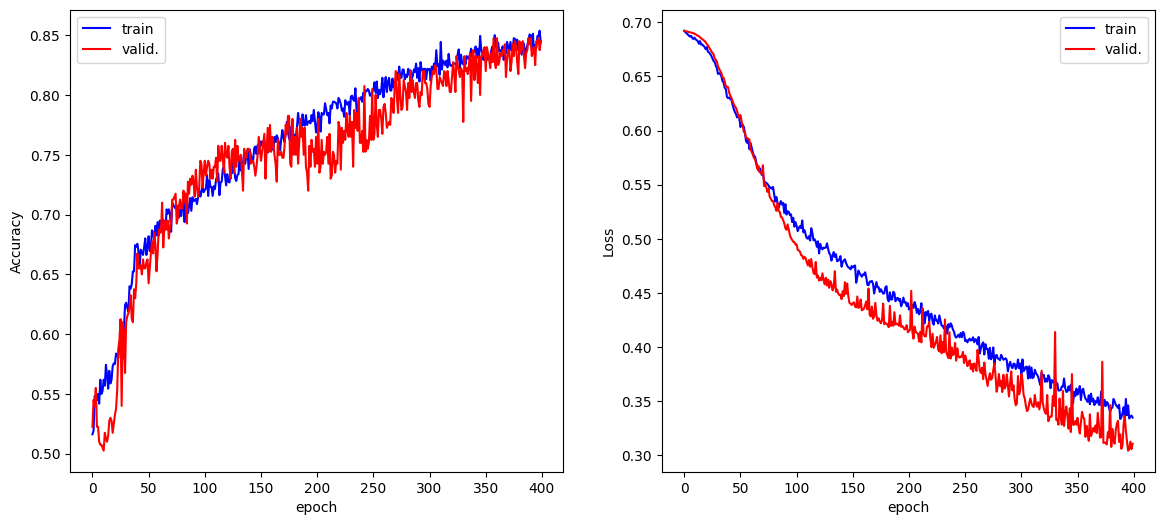

In [8]:
fig,AX=plt.subplots(1,2,figsize=(14,6.))
ax=AX[0]
ax.plot(fit.history['accuracy'],label="train",c="b")
ax.plot(fit.history['val_accuracy'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.legend()
ax=AX[1]
ax.plot(fit.history['loss'],label="train",c="b")
ax.plot(fit.history['val_loss'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

In [9]:
dX = 2
X1 = np.arange(-50,50+dX, dX)
LG = len(X1)
grid = np.zeros((LG*LG,2))
k=0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(X1[j],X1[i])
        k=k+1
print(len(X1),len(grid))
print(grid[-1])

# RESCALE

grid_r = grid/50

pred = model.predict(grid_r)

51 2601
[50. 50.]
82/82 [==============================] - 0s 3ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

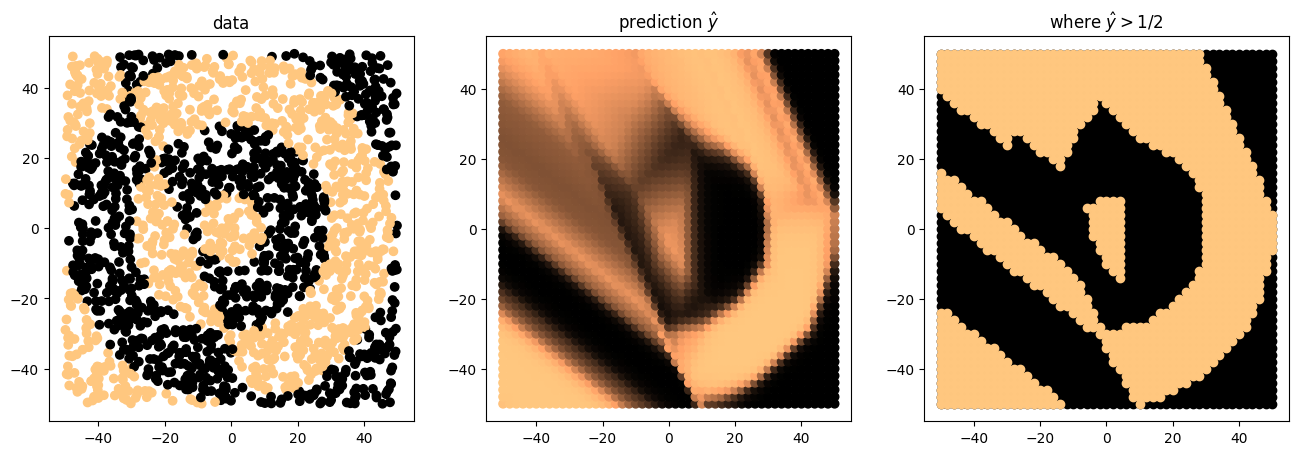

In [10]:
def boundaries():  
    x1=-30
    y1=-30
    c="#AAAAFF"
    a=0.5
    lw=5
    ax.plot((50,-17),(-17,50),c=c,alpha=a,lw=lw)
    ax.plot((50,0),(0,50),c=c,alpha=a,lw=lw)
    ax.plot((x1,50),(y1,y1),c=c,alpha=a,lw=lw)
    ax.plot((x1,x1),(y1,50),c=c,alpha=a,lw=lw)
fig,AX=plt.subplots(1,3,figsize=(16,5.))
ax=AX[0]
ax.scatter(x[:,0],x[:,1],c=y)
if TYPE==1: boundaries()
ax.set_title("data")
ax=AX[1]
ax.scatter(grid[:,0],grid[:,1],c=pred)
if TYPE==1: boundaries()
ax.set_title("prediction $\\hat y$")
ax=AX[2]
W1=np.where(pred>0.5)[0] 
ax.scatter(grid[:,0],grid[:,1],c="#000000")
ax.scatter(grid[W1,0],grid[W1,1],c="#ffc77f")
if TYPE==1: boundaries()
ax.set_title("where $\\hat y > 1/2$")
plt.show
plt.show

In [11]:
TYPE

2